In [2]:
from ase.io import read,write
import matplotlib.pyplot as plt
from ase.build import stack
import numpy as np
from moirecompare.calculators import (NLayerCalculator, 
                                      AllegroCalculator)

from ase.optimize import FIRE

In [3]:
atoms = read("11-70.53_deg-24_atoms.xyz")
# Setting up structure
# IL_sep = 2.0
# bottom_layer_disp = -IL_sep/2 - atoms.positions[atoms.arrays['atom_types'] < 4, 2].max()
# top_layer_disp = IL_sep/2 - atoms.positions[atoms.arrays['atom_types'] >= 4, 2].min()
# atoms.positions[atoms.arrays['atom_types'] < 4, 2] += bottom_layer_disp
# atoms.positions[atoms.arrays['atom_types'] >= 4, 2] += top_layer_disp

In [29]:
atoms = read("11-70.53_deg-24_atoms.xyz")

atoms_L1 = atoms.copy()[atoms.arrays['atom_types']< 4]
atoms_stack = atoms_L1.copy()[:]


In [30]:
for a in range(3):
    tmp_atoms = atoms_L1.copy()
    tmp_atoms.rotate(10, 'z', center='COM')
    tmp_atoms.positions[:,2] += 4.0 * a
    tmp_atoms.arrays['atom_types'] += 4 * a
    atoms_stack = atoms_stack + tmp_atoms

In [32]:
atoms_stack.cell

Cell([[6.58012104664396, 4.652953351524507, 0.0], [3.2790605061304188, -4.63718705508585, 0.0], [0.0, 0.0, 30.10888]])

In [6]:
atoms_L2.rotate(90, 'z', center=(0,0,0))

(-0.49295907763871893,
 10.352140630413098,
 -5.18085791811082,
 6.779901068438521)

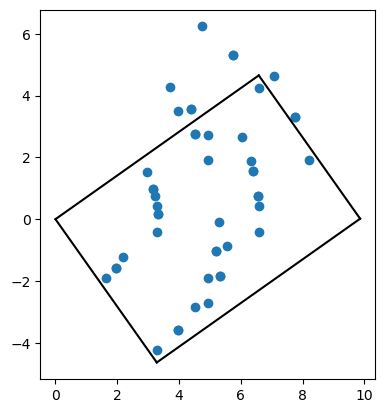

In [7]:
# a_2 = atoms_L1 + atoms_L2 
# atoms_L1.wrap()
plt.scatter(atoms_L1.positions[:,0], atoms_L1.positions[:,1])

p0 = [0,0]
p1 = atoms_L1.cell[0]
p2 = atoms_L1.cell[1] + atoms_L1.cell[0]
p3 = atoms_L1.cell[1]

# plot the cell border 
plt.plot([p0[0], p1[0]], [p0[1], p1[1]], 'k-')
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-')
plt.plot([p2[0], p3[0]], [p2[1], p3[1]], 'k-')
plt.plot([p3[0], p0[0]], [p3[1], p0[1]], 'k-')

# plt.scatter(atoms_L2.positions[:,0], atoms_L2.positions[:,1])

plt.axis('scaled')

In [8]:
atoms_L1.arrays['atom_types']

array([ 3,  0,  1,  2,  3,  0,  1,  3,  2,  0,  1,  2,  7,  4,  5,  6,  7,
        4,  5,  7,  6,  4,  5,  6,  7,  4,  5,  6,  7,  4,  5,  7,  6,  4,
        5,  6, 11,  8,  9, 10, 11,  8,  9, 11, 10,  8,  9, 10],
      dtype=int32)

In [54]:
from ase.visualize import view
view(atoms)

<Popen: returncode: None args: ['/pscratch/sd/j/jdgeorga/ml_iaps/venv_ml_iap...>

usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,nomad-upload,nomad-get,convert,reciprocal,completion,diff,exec}
           ...
ase: error: TclError: no display name and no $DISPLAY environment variable
To get a full traceback, use: ase -T gui ...


In [73]:
atoms = read("11-70.53_deg-24_atoms.xyz")

atoms_L1 = atoms.copy()[atoms.arrays['atom_types']< 4]
atoms_L1.cell[2,2] = 100.0


interlayer_model = "./interlayer_bp.pth"
intralayer_model = "./intralayer_bp.pth"

n_layers = 4

layer_symbols = [['P','P','P', 'P'] for i in range(n_layers)]

a_1 = atoms_L1.copy()[:].repeat([7,7,1])

atoms_stack = a_1.copy()[:]
layer_atoms_list = [a_1]
intra_calc_list = [AllegroCalculator(a_1,
                                     layer_symbols[0],
                                     model_file=intralayer_model)]

inter_calc_list = []
for a in range(n_layers-1):
    tmp_atoms = atoms_L1.copy()[:]
    tmp_atoms = tmp_atoms.repeat([7-2*(a+1),7-2*(a+1),1])
    print(tmp_atoms.cell)
    tmp_atoms.cell = a_1.cell
    tmp_atoms.rotate(10 * (a+1), 'z', center='COM')
    tmp_atoms.positions[:,:2] += (atoms_L1.cell[0] + atoms_L1.cell[1])[:2] * (a+1)
    tmp_atoms.positions[:,2] += 5.0 * (a+1)
    tmp_atoms.arrays['atom_types'] += 4 * (a+1)
    print(tmp_atoms.cell)
    layer_atoms_list.append(tmp_atoms)
    tmp_calc = AllegroCalculator(tmp_atoms,
                                 layer_symbols[a+1],
                                 model_file=intralayer_model)  
    intra_calc_list.append(tmp_calc)
    atoms_stack = atoms_stack + tmp_atoms

    tmp_calc_IL = AllegroCalculator(atoms_stack[np.logical_and(atoms_stack.arrays['atom_types'] >= 4*a,
                                                               atoms_stack.arrays['atom_types'] < 4*(a+2))],
                                       layer_symbols=layer_symbols[a:(a+2)],
                                       model_file=interlayer_model)
    inter_calc_list.append(tmp_calc_IL)



# at_1 = atoms_L1[atoms_L1.arrays['atom_types'] < 4]
# at_2 = atoms_L1[np.logical_and(atoms_L1.arrays['atom_types'] >= 4,
#                          atoms_L1.arrays['atom_types'] < 8)]

# intra_calc_1 = AllegroCalculator(at_1,
#                                layer_symbols[0],
#                                 model_file=intralayer_model)
# intra_calc_2 = AllegroCalculator(at_2,
#                                layer_symbols[1],
#                                 model_file=intralayer_model)

# calc_IL_1 = AllegroCalculator(atoms_L1[atoms_L1.arrays['atom_types'] < 8],
#                                        layer_symbols=layer_symbols[0:2],
#                                        model_file=interlayer_model)

nlayer_calc = NLayerCalculator(atoms_stack,
                               intra_calc_list, 
                               inter_calc_list,
                               layer_symbols=layer_symbols)

write("stack.cif", atoms_stack,format = 'cif')

4 4
Cell([[32.9006052332198, 23.26476675762254, 0.0], [16.395302530652096, -23.185935275429248, 0.0], [0.0, 0.0, 100.0]])
Cell([[46.06084732650772, 32.57067346067155, 0.0], [22.95342354291293, -32.46030938560095, 0.0], [0.0, 0.0, 100.0]])
4 4
8 8
Cell([[19.74036313993188, 13.958860054573522, 0.0], [9.837181518391256, -13.911561165257549, 0.0], [0.0, 0.0, 100.0]])
Cell([[46.06084732650772, 32.57067346067155, 0.0], [22.95342354291293, -32.46030938560095, 0.0], [0.0, 0.0, 100.0]])
4 4
8 8
Cell([[6.58012104664396, 4.652953351524507, 0.0], [3.2790605061304188, -4.63718705508585, 0.0], [0.0, 0.0, 100.0]])
Cell([[46.06084732650772, 32.57067346067155, 0.0], [22.95342354291293, -32.46030938560095, 0.0], [0.0, 0.0, 100.0]])
4 4
8 8


In [107]:
atoms = read("11-70.53_deg-24_atoms.xyz")
atoms.cell[2,2] = 100.0

atoms_L1 = atoms.copy()[atoms.arrays['atom_types'] < 4]
atoms_L2 = atoms.copy()[atoms.arrays['atom_types'] >= 4]
atoms_L2.positions[:,2] += 12.0
# atoms_L1.cell[2,2] = 100.0


interlayer_model = "./interlayer_bp.pth"
intralayer_model = "./intralayer_bp.pth"

n_layers = 8

layer_symbols = [['P','P','P', 'P'] for i in range(n_layers)]

atoms_stack = atoms_L1.copy()[:]
layer_atoms_list = [atoms_L1]
intra_calc_list = [AllegroCalculator(atoms_L1,
                                     layer_symbols[0],
                                     model_file=intralayer_model)]

inter_calc_list = []
for a in range(n_layers-1):
    if a % 2 == 0:
        tmp_atoms = atoms_L2.copy()[:]
    if a%2 == 1:    
        tmp_atoms = atoms_L1.copy()[:]

    tmp_atoms.positions[:,2] += 5.0 * (a+1)
    tmp_atoms.arrays['atom_types'] =  tmp_atoms.arrays['atom_types'] % 4 + 4 * (a+1)
    print(tmp_atoms.positions[:,2].mean())
    layer_atoms_list.append(tmp_atoms)
    tmp_calc = AllegroCalculator(tmp_atoms,
                                 layer_symbols[a+1],
                                 model_file=intralayer_model)  
    intra_calc_list.append(tmp_calc)
    atoms_stack = atoms_stack + tmp_atoms
    print(atoms_stack.arrays['atom_types'])

    tmp_calc_IL = AllegroCalculator(atoms_stack[np.logical_and(atoms_stack.arrays['atom_types'] >= 4*a,
                                                               atoms_stack.arrays['atom_types'] < 4*(a+2))],
                                       layer_symbols=layer_symbols[a:(a+2)],
                                       model_file=interlayer_model)

    inter_calc_list.append(tmp_calc_IL)



# at_1 = atoms_L1[atoms_L1.arrays['atom_types'] < 4]
# at_2 = atoms_L1[np.logical_and(atoms_L1.arrays['atom_types'] >= 4,
#                          atoms_L1.arrays['atom_types'] < 8)]

# intra_calc_1 = AllegroCalculator(at_1,
#                                layer_symbols[0],
#                                 model_file=intralayer_model)
# intra_calc_2 = AllegroCalculator(at_2,
#                                layer_symbols[1],
#                                 model_file=intralayer_model)

# calc_IL_1 = AllegroCalculator(atoms_L1[atoms_L1.arrays['atom_types'] < 8],
#                                        layer_symbols=layer_symbols[0:2],
#                                        model_file=interlayer_model)

nlayer_calc = NLayerCalculator(atoms_stack,
                               intra_calc_list, 
                               inter_calc_list,
                               layer_symbols=layer_symbols)

write("stack.cif", atoms_stack,format = 'cif')

/pscratch/sd/j/jdgeorga/ml_iaps/nequip/nequip/utils/_global_options.py:59: UserWarning: !! Upstream issues in PyTorch versions >1.11 have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. At present we *strongly* recommend the use of PyTorch 1.11 if using CUDA devices; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(
/pscratch/sd/j/jdgeorga/ml_iaps/nequip/nequip/utils/_global_options.py:103: UserWarning: Do NOT manually set PYTORCH_JIT_USE_NNC_NOT_NVFUSER=0 unless you know exactly what you're doing!
  warnings.warn(


4 4
4.89112
4 4
[3 0 1 2 3 0 1 3 2 0 1 2 5 5 6 7 4 5 6 7 4 6 7 4]
8 8
10.0
4 4
[ 3  0  1  2  3  0  1  3  2  0  1  2  5  5  6  7  4  5  6  7  4  6  7  4
 11  8  9 10 11  8  9 11 10  8  9 10]
8 8
14.89112
4 4
[ 3  0  1  2  3  0  1  3  2  0  1  2  5  5  6  7  4  5  6  7  4  6  7  4
 11  8  9 10 11  8  9 11 10  8  9 10 13 13 14 15 12 13 14 15 12 14 15 12]
8 8
20.0
4 4
[ 3  0  1  2  3  0  1  3  2  0  1  2  5  5  6  7  4  5  6  7  4  6  7  4
 11  8  9 10 11  8  9 11 10  8  9 10 13 13 14 15 12 13 14 15 12 14 15 12
 19 16 17 18 19 16 17 19 18 16 17 18]
8 8
24.89112
4 4
[ 3  0  1  2  3  0  1  3  2  0  1  2  5  5  6  7  4  5  6  7  4  6  7  4
 11  8  9 10 11  8  9 11 10  8  9 10 13 13 14 15 12 13 14 15 12 14 15 12
 19 16 17 18 19 16 17 19 18 16 17 18 21 21 22 23 20 21 22 23 20 22 23 20]
8 8
30.0
4 4
[ 3  0  1  2  3  0  1  3  2  0  1  2  5  5  6  7  4  5  6  7  4  6  7  4
 11  8  9 10 11  8  9 11 10  8  9 10 13 13 14 15 12 13 14 15 12 14 15 12
 19 16 17 18 19 16 17 19 18 16 17 18 21 21 22 23 20 2

In [105]:
atoms_L1.positions[:,2].mean()

0.0

(-0.06623773850000003, 9.9254192885, -4.649343765, 4.665110065)

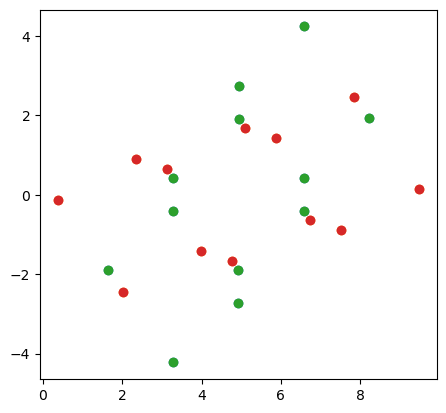

In [87]:
lll = [atoms[atoms.arrays['atom_types'] < 4] ,
       atoms[atoms.arrays['atom_types'] >= 4]]
for i in range(4):
    plt.scatter(layer_atoms_list[i].positions[:,0], layer_atoms_list[i].positions[:,1])

plt.axis('scaled')

In [106]:
print(layer_symbols[0:2])
atoms_stack.calc = nlayer_calc
atoms_stack.calc.calculate(atoms_stack)

print(f"Unrelaxed: Total_energy {atoms_stack.calc.results['energy']:.3f} eV, \n",
      f"layer_energy {atoms_stack.calc.results['layer_energy']}")

dyn = FIRE(atoms_stack,trajectory = 'octo_BP_relax.traj')
dyn.run(fmax=5e-3, maxsteps=1000)

print(f"Relaxed: Total_energy {atoms_stack.calc.results['energy']:.3f} eV, \n",
      f"layer_energy {atoms_stack.calc.results['layer_energy']}")


[['P', 'P', 'P', 'P'], ['P', 'P', 'P', 'P']]
Unrelaxed: Total_energy -4.064 eV, 
 layer_energy [[ 0.16683166 -0.5722838   0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.16683193 -1.03657186  0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.16683084 -0.57228667  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.16683193 -1.03657186  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.16683084 -0.57228422
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.16683131
  -1.0365721   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.16683084 -0.57228804]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.16683099]]
      Step     Time          Energy         fmax
FIRE:    0 00:05:00       -4.064208        0.7211
FIRE:    1 00:05:03       -4.198228        0.

In [23]:
print(layer_symbols[0:2])
atoms_L1.calc = nlayer_calc
atoms_L1.calc.calculate(atoms_L1)

print(f"Unrelaxed: Total_energy {atoms_L1.calc.results['energy']:.3f} eV, \n",
      f"layer_energy {atoms_L1.calc.results['layer_energy']}")

dyn = FIRE(atoms_L1,trajectory = 'tri_BP_relax.traj')
dyn.run(fmax=5e-3)

print(f"Relaxed: Total_energy {atoms_L1.calc.results['energy']:.3f} eV, \n",
      f"layer_energy {atoms_L1.calc.results['layer_energy']}")


[['P', 'P', 'P', 'P'], ['P', 'P', 'P', 'P']]
Unrelaxed: Total_energy 6.625 eV, 
 layer_energy [[0.16683149 0.        ]
 [0.         6.45777416]]
      Step     Time          Energy         fmax
FIRE:    0 17:21:37        6.624606        1.3439
FIRE:    1 17:21:38        6.461376        1.2559
FIRE:    2 17:21:39        6.194279        1.0607
FIRE:    3 17:21:39        5.924542        0.7121
FIRE:    4 17:21:39        5.733362        0.7697
FIRE:    5 17:21:39        5.606447        0.9770
FIRE:    6 17:21:40        5.480617        0.8394
FIRE:    7 17:21:40        5.352620        0.7405
FIRE:    8 17:21:40        5.263427        0.7125
FIRE:    9 17:21:40        5.259137        0.7839
FIRE:   10 17:21:41        5.238547        0.7208
FIRE:   11 17:21:41        5.201990        0.6515
FIRE:   12 17:21:41        5.157189        0.6423
FIRE:   13 17:21:41        5.112148        0.6263
FIRE:   14 17:21:42        5.071944        0.5979
FIRE:   15 17:21:42        5.036887        0.6095
FIRE: 

In [25]:
atoms_L1.positions

array([[ 1.64161184, -1.89953582, -3.10347581],
       [ 3.28246074, -4.24136239, -1.00025047],
       [ 4.92384725, -2.71600703, -1.00402458],
       [ 3.28298892, -0.40695748, -3.11000924],
       [ 4.92800577, -1.89428045, -3.10347569],
       [ 3.28979423,  0.40107987, -1.0002505 ],
       [ 4.93118055,  1.92643525, -1.00402457],
       [ 4.93533923,  2.74816177, -3.10347579],
       [ 6.56938283, -0.40170221, -3.11000914],
       [ 6.57618782,  0.40633514, -1.00025066],
       [ 8.21757423,  1.93169058, -1.00402471],
       [ 6.57671599,  4.2407404 , -3.11000913],
       [ 2.05124765, -1.56640586, 31.52041395],
       [ 4.24830633, -3.65264427, 33.68515662],
       [ 5.47457665, -1.82688835, 33.69357634],
       [ 3.46073189,  0.15584152, 31.64927572],
       [ 5.33891245, -1.09237428, 31.53792205],
       [ 3.21627276,  0.91162504, 33.75704525],
       [ 4.38093706,  2.76865138, 33.60757863],
       [ 4.30629604,  3.55343145, 31.45357817],
       [ 6.47458635,  0.76743922, 31.384

In [21]:
atoms[atoms.arrays['atom_types'] < 8]

Atoms(symbols='P24', pbc=True, cell=[[6.58012104664396, 4.652953351524507, 0.0], [3.2790605061304188, -4.63718705508585, 0.0], [0.0, 0.0, 30.10888]], atom_types=..., spacegroup_kinds=...)